<a href="https://colab.research.google.com/github/Mr-Grag-Universe/NLA_project/blob/main/SVD_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random SVD

In [ ]:
import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt


In [ ]:
m, n, r = 1000, 500, 100
X = Image.open("cat_2.jpg")
X = np.array(X, dtype=np.uint8)
X.shape
X = np.random.randn(1000, 600)

Идея:

* давайте схлопнем наше пространство данных X
* потом посмотрим разложения матриц меньшего размера
* получим матрицу перехода в пространство меньшей размерности для X

In [ ]:
def RandomSVD(X, r):
    P = np.random.randn(X.shape[1], r)
    Z = X @ P
    Q, R = np.linalg.qr(Z, mode="reduced")
    Y = Q.conj().T @ X
    U_y, S, V = np.linalg.svd(Y, full_matrices=False)
    U = Q @ U_y

    return U, S, V

Улучшения:
* можно определять оптимальную ширину (размерность) итогового пространства автоматически
* для значительного повышения точности малыми усилиями можно сделать припуск в 5/10 дополнительных столбцов
* Также для сильного увеличения точности можно брать разложение от степени матрицы, но это довольно затратно

In [ ]:
def superRandomSVD(X, r=None, eps=None, power_iter=None):
    m, n = X.shape
    if r is None:
        assert eps is not None, "not None eps must be passed with r=None"
        Omega = np.random.randn(n, 1)
        # я не вполне понимаю, как это делается

    P = np.random.randn(n, r)
    Z = X @ P
    if power_iter:
        for i in range(power_iter):
            Z = X @ (X.T @ Z)

    Q, R = np.linalg.qr(Z, mode="reduced")
    Y = Q.conj().T @ X
    U_y, S, V = np.linalg.svd(Y, full_matrices=False)
    U = Q @ U_y

    return U, S, V

In [ ]:
X_compressed = np.zeros_like(X)

S_vals = []
S3_vals = []
for i in range(X.shape[-1]-2):
    U, S, V = superRandomSVD(X, r=150)
    U3, S3, V3 = superRandomSVD(X, r=150, power_iter=3)
    S_m = np.diagflat(S)
    X_compressed = U @ S_m @ V
    print(np.linalg.norm(X_compressed - U @ S_m @ V))
    S_vals.append(S)
    S3_vals.append(S3)
    break

0.0


In [ ]:
S_vals[0][0], S3_vals[0][0]

(534931.2024388665, 534946.2146473345)

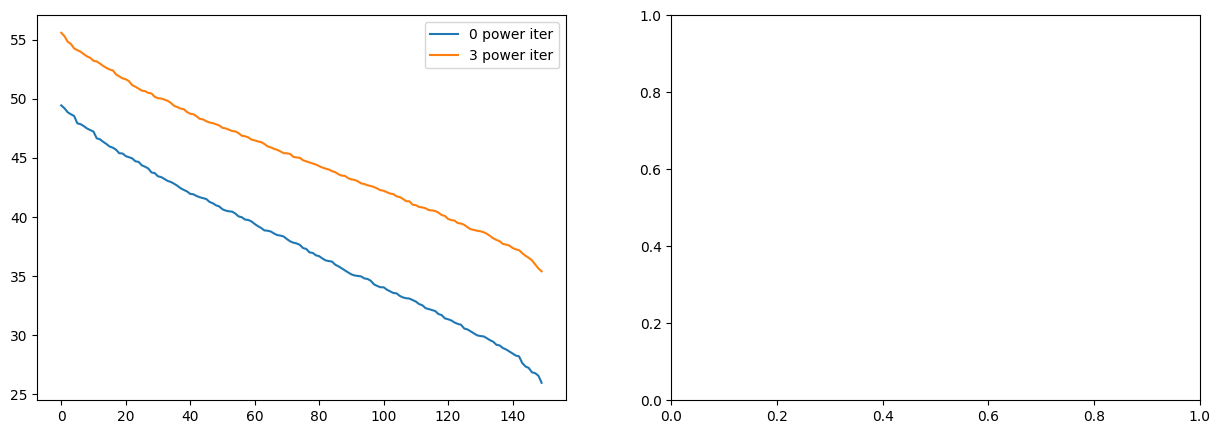

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5), ncols=2, nrows=1)
ax[0].plot(S_vals[0][:], label="0 power iter")
ax[0].plot(S3_vals[0][:], label="3 power iter")
# ax[1].plot(S_vals[1][1:])
# ax[2].plot(S_vals[2][1:])
ax[0].legend()

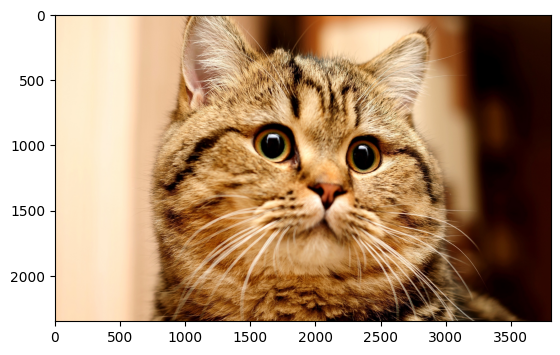

In [ ]:
from matplotlib.pyplot import imshow
imshow(X)

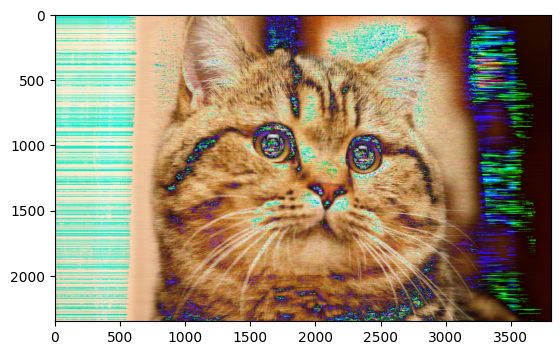

In [ ]:
imshow(X_compressed)

# Метод Якоби

Их существует 2 основных варианта:
* Jacobi-Kogbetliznt algorithm or double-sided Jacobi method
* Jacobi-Hestenes algorithm or single-sided Jacobi algorithm

## Double Sided Jacobi Method

Основная идея - занулить всё, что не на диагонали

Формула приведения к диагональному виду выглядит так:

$S = J_{lk} J_{l(k-1)} ... J_{l0} A J_{r0} ... J_{r(k-1) J_{rk}} = U^* A V$

Тогда матрицы левых и правых сингулярных векторов имеют вид:

$U^* = J_{lk} J_{l(k-1)} ... J_{l0}$

$V = J_{l0} A J_{r0} ... J_{r(k-1) J_{rk}}$

Пользуемся SVD 2x2

In [ ]:
n = 5
eps = 1e-6
X = np.random.randn(n, n)

In [ ]:
X_i = X.copy()
J = np.eye(n, n)
err = []
U_res = np.eye(n, n)
V_res = np.eye(n, n)
for iter in range(1000):
    # ищем максимальный недиагональный элемент
    M = np.abs(X_i[0, 1])
    ind = (0, 1)
    for i in range(0, n-1):
        for j in range(i+1, n):
            m = np.max([np.abs(X_i[i, j]), np.abs(X_i[j, i])])
            if m > M:
                ind = (i, j)
                M = m
    # print("max: ", M)
    # print("i, j: ", ind)

    # теперь вращаем относительно этого максимума
    i, j = ind
    A = np.asarray([
        [X_i[i,i], X_i[i,j]],
        [X_i[j,i], X_i[j,j]]
    ])
    # print(A)

    U, S, Vh = np.linalg.svd(A)
    Uh = U.T
    V = Vh.T

    # применяем матрицы перехода к X
    X_row = np.asarray([X_i[i].copy(), X_i[j].copy()])
    X_row = Uh @ X_row
    X_i[i], X_i[j] = X_row
    X_col = np.asarray([X_i[:,i].copy(), X_i[:,j].copy()]).T
    X_col = X_col @ V
    X_i[:,i], X_i[:,j] = X_col.T

    # стакаем матрицы перехода U
    U_m = np.asarray([U_res[:,i].copy(), U_res[:,j].copy()])
    U_m = (U_m.T @ U).T
    U_res[:,i], U_res[:,j] = U_m
    # стакаем матрицы перехода V
    V_m = np.asarray([V_res[:,i].copy(), V_res[:,j].copy()]).T
    V_m = V_m @ V
    V_res[:,i], V_res[:,j] = V_m.T

    # print(X_i)

X_i

array([[ 3.35255069e+00, -6.72955121e-15,  8.53976248e-22,
         2.58493941e-26, -1.69938741e-24],
       [ 0.00000000e+00,  2.81894193e+00, -2.66491413e-23,
        -1.60316309e-22, -6.31088725e-30],
       [-5.99387078e-18,  1.60278431e-24,  1.93728600e+00,
         7.25336516e-40,  2.06855828e-25],
       [-9.41427741e-27,  3.26607948e-23, -6.93772113e-31,
         1.05779563e+00, -7.88861385e-31],
       [-2.34068358e-24,  6.80742575e-33,  1.58154773e-26,
         5.51571478e-30,  1.73623008e-02]])

In [ ]:
U, S, V_h = np.linalg.svd(X)
S

array([3.35255069, 2.81894193, 1.937286  , 1.05779563, 0.0173623 ])

In [ ]:
print(U)
print(U_res)

[[-0.46925081  0.4092485  -0.72491384 -0.28048152 -0.0902739 ]
 [-0.72660085 -0.65517904  0.02710125  0.20164068 -0.03739237]
 [ 0.19664723 -0.04859012 -0.21001818  0.41955729 -0.8595539 ]
 [ 0.32601032 -0.57413055 -0.24768894 -0.68870436 -0.16860567]
 [ 0.32695874 -0.26696291 -0.60688384  0.47992618  0.47243163]]
[[-0.46925081  0.4092485  -0.72491384 -0.28048152  0.0902739 ]
 [-0.72660085 -0.65517904  0.02710125  0.20164068  0.03739237]
 [ 0.19664723 -0.04859012 -0.21001818  0.41955729  0.8595539 ]
 [ 0.32601032 -0.57413055 -0.24768894 -0.68870436  0.16860567]
 [ 0.32695874 -0.26696291 -0.60688384  0.47992618 -0.47243163]]


In [ ]:
np.linalg.norm(X - U_res @ X_i @ V_res.T)

1.5411203692747293e-14

## Single Sided Jacobi Method

Вместо сингулярного разложения пользуемся разложением Шура

In [ ]:
n = 5
eps = 1e-15
X = np.random.randn(n, n)

In [ ]:
def rotate(Y, X, i, j, eps):
    if i > j:
        i, j = j, i
    a_ii, a_jj, a_ij = Y[i,i], Y[j,j], Y[i,j]
    if np.abs(a_ij) > eps:
        tau = (a_ii - a_jj)/(2*a_ij)
        t = np.sign(tau)/(np.abs(tau) + np.sqrt(1 + tau**2))
        c = 1/(np.sqrt(1 + t**2))
        s = c*t
        x_i = X[:,i].copy()
        x_j = X[:,j].copy()
        X[:,i] = c * x_i + s * x_j
        X[:,j] = -s *  x_i + c * x_j
        return c, s

X_i = X.copy()
J = np.eye(n, n)
err = []
for iter in range(100000):
    Y = X_i.T @ X_i
    flag = 1
    for i in range(0, n-1):
        for j in range(i+1, n):
            if np.abs(Y[i, j]) > eps:
                flag = 0
                c, s = rotate(Y, X_i, i, j, eps=eps)
                j_i = J[:,i].copy()
                j_j = J[:,j].copy()
                J[:,i] = c * j_i + s * j_j
                J[:,j] = -s *  j_i + c * j_j
                break

        if flag==0:
            break

    err += [1]

    if flag:
        break

Y

array([[ 1.14074486e+01, -2.32916707e-16, -5.08633952e-16,
        -4.09330193e-16,  4.73410248e-16],
       [-2.32916707e-16,  1.13875039e-01,  6.44586181e-16,
        -6.12171791e-16, -3.23638548e-16],
       [-5.08633952e-16,  6.44586181e-16,  1.50472094e+00,
         5.45266473e-16,  4.41253839e-16],
       [-4.09330193e-16, -6.12171791e-16,  5.45266473e-16,
         6.12776969e+00, -2.36040326e-16],
       [ 4.73410248e-16, -3.23638548e-16,  4.41253839e-16,
        -2.36040326e-16,  2.53427288e+00]])

In [ ]:
S = np.linalg.norm(X_i, axis=0)
U = np.zeros_like(X)
for i in range(n):
    U[:,i] = X_i[:,i] / S[i]
V = J

In [ ]:
print(U.shape)
print(S.shape)
print(V.shape)
print(len(err))

(5, 5)
(5,)
(5, 5)
1367


In [ ]:
np.linalg.norm(X - U @ np.diagflat(S) @ V.T)

6.755096503050416e-14

In [ ]:
(U.T @ U)

array([[ 1.00000000e+00, -2.59537696e-16, -8.98344127e-17,
        -1.66450629e-17,  1.25848867e-16],
       [-2.59537696e-16,  1.00000000e+00,  1.65886203e-15,
        -6.90861815e-16, -5.64547987e-16],
       [-8.98344127e-17,  1.65886203e-15,  1.00000000e+00,
         1.74301885e-16,  2.07706748e-16],
       [-1.66450629e-17, -6.90861815e-16,  1.74301885e-16,
         1.00000000e+00, -3.85172280e-17],
       [ 1.25848867e-16, -5.64547987e-16,  2.07706748e-16,
        -3.85172280e-17,  1.00000000e+00]])

In [ ]:
V.T @ V

array([[ 1.00000000e+00, -3.34615064e-16,  1.13517668e-15,
        -9.72380520e-16, -3.81161400e-16],
       [-3.34615064e-16,  1.00000000e+00,  9.33474424e-16,
        -3.16116896e-16, -1.05535493e-15],
       [ 1.13517668e-15,  9.33474424e-16,  1.00000000e+00,
        -4.49427082e-15,  2.17547094e-15],
       [-9.72380520e-16, -3.16116896e-16, -4.49427082e-15,
         1.00000000e+00, -2.54478003e-16],
       [-3.81161400e-16, -1.05535493e-15,  2.17547094e-15,
        -2.54478003e-16,  1.00000000e+00]])

# Метод разделяй и властвуй

Преобразованиями Хаусхолдера доводим матрицу до верхнегиссенберговой формы

Потом в трёхдиагональную

Раскладываем трёхдиагональную матрицу

In [ ]:
n = 4
A = np.random.randn(n, n)

In [ ]:
def generate_H(x):
    n = len(x)
    v = x.copy()
    norm_x = np.linalg.norm(x)
    v[0] -= norm_x
    v /= -np.sqrt(2 * (norm_x**2 - x[0] * (norm_x)))
    H = np.eye(n) - 2 * np.outer(v, v)
    return H

In [ ]:
def get_B(A):
    n = A.shape[0]
    A_i = A.copy()
    H_l_res = np.eye(A.shape[0])
    H_r_res = np.eye(A.shape[0])
    for i in range(0, n-1):
        # левая матрица перехода
        try:
            H_ = generate_H(A_i[i:,i])
        except RuntimeWarning:
            continue
        H_l = np.eye(n)
        H_l[i:,i:] = H_

        A_i = H_l @ A_i
        # print(A_i.round(3))
        H_l_res = H_l_res @ H_l

        # правая матрица перехода
        if i < n-1:
            H_ = generate_H(A_i[i,i+1:])
            H_r = np.eye(n)
            H_r[i+1:,i+1:] = H_

            A_i = A_i @ H_r.T
            # print(A_i.round(3))

            H_r_res = H_r_res @ H_r

    return A_i, H_l_res, H_r_res

In [ ]:
B = A_i.copy()

Получили верхнегиссенбергову двухдиагональную форму матрицы

## Через QR разложение

### Тестики

In [ ]:
(B @ B.T).round(3)

array([[ 6.885,  3.2  , -0.   ,  0.   ],
       [ 3.2  , 10.028,  2.275,  0.   ],
       [-0.   ,  2.275,  4.607,  0.049],
       [ 0.   ,  0.   ,  0.049,  1.04 ]])

если я правильно понял - берём B и докручиваем до диагонального вида матрицами поворота

In [ ]:
T = B.T @ B

Q, R = np.linalg.qr(T)
print("Q:\n", Q.round(3))
print("R:\n", R.round(3))

M = R @ Q
print("T:\n", T.round(3))
print("RQ:\n", M.round(3))

Q:
 [[-0.913  0.381 -0.148 -0.004]
 [-0.409 -0.85   0.331  0.008]
 [ 0.    -0.363 -0.932 -0.023]
 [ 0.    -0.    -0.024  1.   ]]
R:
 [[-6.284 -6.454 -1.293 -0.   ]
 [ 0.    -8.72  -4.769 -0.038]
 [ 0.     0.    -4.292 -0.122]
 [ 0.     0.     0.     1.039]]
T:
 [[ 5.735  2.568 -0.    -0.   ]
 [ 2.568 10.054  3.164  0.   ]
 [-0.     3.164  5.729  0.104]
 [-0.     0.     0.104  1.042]]
RQ:
 [[ 8.373  3.564  0.     0.   ]
 [ 3.564  9.147  1.557 -0.   ]
 [-0.     1.557  4.001 -0.025]
 [ 0.    -0.    -0.025  1.039]]


In [ ]:
def rotate(Y, X, i, j, eps):
    if i > j:
        i, j = j, i
    a_ii, a_jj, a_ij = Y[i,i], Y[j,j], Y[i,j]
    tau = (a_ii - a_jj)/(2*a_ij)
    t = np.sign(tau)/(np.abs(tau) + np.sqrt(1 + tau**2))
    c = 1/(np.sqrt(1 + t**2))
    s = c*t
    x_i = X[:,i].copy()
    x_j = X[:,j].copy()
    X[:,i] = c * x_i + s * x_j
    X[:,j] = -s *  x_i + c * x_j
    return c, s

In [ ]:
for i in range(1, n):
    c, s =

### Нормальный алгоритм

In [ ]:
def rot(X, i, j, eps=1e-10):
    a_ii, a_jj, a_ij = X[i,i], X[j,j], X[i,j]
    tau = (a_jj-a_ii) / (2*a_ij)
    # t = -tau + np.sqrt(1+tau**2)
    # if np.abs(t) > 1:
    #     t = -tau - np.sqrt(1+tau**2)

    t = np.sign(tau)/(np.abs(tau) + np.sqrt(1 + tau**2))
    c = 1/np.sqrt(1+t**2)
    s = c*t
    return c, s

In [ ]:
def apply_h(X, c, s, i, j, mode="right"):
    if mode == "right":
        x1, x2 = X[:,i].copy(), X[:,j].copy()
        X[:,i] = c*x1 - s*x2
        X[:,j] = s*x1 + c*x2
    elif mode == "left":
        x1, x2 = X[i,:].copy(), X[j,:].copy()
        X[i,:] = c*x1 - s*x2
        X[j,:] = s*x1 + c*x2


In [ ]:
def qr_sweep(B):
    m, n = B.shape
    U = np.eye(m)
    V = np.eye(n)
    for k in range(0, m-1):
        c, s = rot(B, k, k+1)
        apply_h(B, c, s, k, k+1, mode="right")
        apply_h(B, c, s, k, k+1, mode="left")
        print("B:\n", B.round(3))
        apply_h(U, c, s, k, k+1, mode="right")
        apply_h(V, c, s, k, k+1, mode="left")
        # опционально обнуляем элементы близкие к 0
        B[np.abs(B) < 1e-13] = 0

    E = np.linalg.norm(np.ma.array(B, mask=~np.eye(B.shape[0], dtype=bool)))

    return U, V, E


In [ ]:
U2 = np.eye(B.shape[0])
V2 = np.eye(B.shape[0])

print(~np.eye(B.shape[0], dtype=bool))
print(np.ma.array(B, mask=~np.eye(B.shape[0], dtype=bool)).round(3))
print("error: ", E)
i = 0
T = (B.T@B)
T_i = T.copy()
E = np.linalg.norm(np.ma.array(T_i, mask=~np.eye(T_i.shape[0], dtype=bool)))
while E > 1e-8 and i < 100:
    Q, R = np.linalg.qr(T_i)
    T_i = R.dot(Q)
    E = np.linalg.norm(np.ma.array(T_i, mask=~np.eye(T_i.shape[0], dtype=bool)))
    i += 1

print("error: ", E)
T_i.round(3)

[[False  True  True  True]
 [ True False  True  True]
 [ True  True False  True]
 [ True  True  True False]]
[[2.395 -- -- --]
 [-- 2.984 -- --]
 [-- -- 2.146 --]
 [-- -- -- 1.02]]
error:  14.181509678124447
error:  14.181509678124447


array([[12.506, -0.   ,  0.   ,  0.   ],
       [ 0.   ,  5.733, -0.   ,  0.   ],
       [-0.   ,  0.   ,  3.282, -0.   ],
       [-0.   ,  0.   ,  0.   ,  1.039]])

In [ ]:
2.4031481026965746

### Итоговый вариант

Это вариант решения задачи через QR разложение в лоб:

In [ ]:
T_i = T.copy()
E = np.linalg.norm(np.ma.array(T_i, mask=~np.eye(T_i.shape[0], dtype=bool)))
U = np.eye(T.shape[0])
i = 0
while E > 1e-8 and i < 1000:
    Q, R = np.linalg.qr(T_i) # тут должен быть неявный QR-алгоритм
    T_i = R.dot(Q)
    E = np.linalg.norm(np.ma.array(T_i, mask=~np.eye(T_i.shape[0], dtype=bool)))
    i += 1
    U = U @ Q

print("error: ", E)
print("S: \n", T_i.round(3))
print("Применяем к матрице: \n", (U.T @ T @ U).round(3))

error:  14.181509678124447
S: 
 [[12.506 -0.    -0.     0.   ]
 [ 0.     5.733  0.     0.   ]
 [ 0.    -0.     3.282  0.   ]
 [ 0.     0.     0.     1.039]]
Применяем к матрице: 
 [[12.506 -0.    -0.     0.   ]
 [-0.     5.733  0.     0.   ]
 [-0.     0.     3.282 -0.   ]
 [ 0.     0.    -0.     1.039]]


## Теперь к разделению

In [ ]:
X = np.random.randn(30, 30)
B, H_l, H_r = get_B(X)

In [ ]:
B

array([[ 3.75753298e+00,  2.88249749e+00, -2.27080095e-16,
        -2.80469874e-16,  6.54975235e-16],
       [ 7.20530163e-17,  1.54618248e+00,  2.54045981e+00,
        -1.94711700e-16, -6.22808837e-16],
       [ 5.27069643e-17,  5.84084239e-17,  6.65236153e-01,
         8.09185354e-01,  7.41565231e-17],
       [-2.28009539e-17, -6.09776784e-17,  2.40771207e-17,
         3.02748345e-01,  3.21748917e-01],
       [ 6.40849840e-17,  5.82153124e-17, -1.31191393e-16,
        -6.13026912e-17, -2.20061828e-01]])

In [ ]:
T = B.T @ B

In [ ]:
T

In [ ]:
def Decompose(T):
    T_i = T.copy()
    E = np.linalg.norm(np.ma.array(T_i, mask=~np.eye(T_i.shape[0], dtype=bool)))
    U = np.eye(T.shape[0])
    i = 0
    while E > 1e-9 and i < 1000:
        Q, R = np.linalg.qr(T_i) # тут должен быть неявный QR-алгоритм
        T_i = R.dot(Q)
        E = np.linalg.norm(np.ma.array(T_i, mask=~np.eye(T_i.shape[0], dtype=bool)))
        i += 1
        U = U @ Q
    return U, np.diag(T_i)

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def NewtonMethod(d1, d2, d, rho, u, n, f, df, eps=1e-10):
    # немодифицированный метод Ньютона
    # полностью отлажен и работает
    flag = False
    if d2 == abs(d1)*100:
        flag = True
    x1 = (d1+d2)/2
    x2 = d1
    i = 4
    while np.abs(x1 - x2) > eps:
        x2 = x1
        f_x1 = f(d, rho, u, x1, n)
        # df_x1 = df(d, rho, u, x1, n)
        df_sp = df(d, rho, u, x1, n) + 1e-10
        step = f_x1 / df_sp
        # if (step > 0 and step >= d2-x1) or  (step < 0 and step < d1-x1):
        x1 -= np.sign(step) * np.min([(d2-x1)/10, (x1-d1)/10, np.abs(step) / 10])
        # else:
        # x1 -= step
        if flag and d2 - x1 < 1:
            d2 = abs(d2) * 2
            x2 -= 1
        i += 1
        # print(x1, x2)

    return x1

In [ ]:
def f(d, rho, u, l, n):
    return 1 + rho * np.sum([u[i]**2 / (d[i]-l) for i in range(n)])

def df_sp(d, rho, u, l, n):
    return rho * np.sum([u[i]**2 / (d[i]-l)**2 for i in range(n)])

def SolveD(d, b, u, m):
    n = d.size
    u = u.reshape(n, 1)

    d_p = zip(d, range(n))
    d_sorted = sorted(d_p)
    p = np.asarray([d_i[1] for d_i in d_sorted])
    d = np.asarray([d_i[0] for d_i in d_sorted])
    # print("d: ", d)
    # d_sorted = sorted(zip(p, range(n)))
    # p1 = np.asarray([d_i[0] for d_i in d_sorted])

    # u = np.linalg.solve((u@u.T)[:,p1]-np.eye(n), np.zeros((n, 1)))
    # print("u: ", u)

    eigvals = np.sort(np.linalg.eigvals(np.diagflat(d) + b * u @ u.T))
    d = np.asarray(d.tolist() + [abs(d[-1])*100])
    L = []
    Q = np.ones((n, 1))

    print("EGV: ", eigvals)
    for i in range(n):
        l = NewtonMethod(d[i], d[i+1], d[:-1], b, u, n, f, df_sp)
        print(l)
        if np.abs(l-eigvals[i])/np.abs(eigvals[i]) > 0.1:
            print("ERRORROOROOROR vals are not the same")
            raise "STOOOOP"
        L.append(l)
        # print("q: \n", q)
        # q = np.zeros_like(d[:-1])
        # if all(d-l):
        #     q = (d[:-1] - l)
        #     for j, q_i in enumerate(q):
        #         q[i] = u[j]/q_i
        # else:
        #     print("ERRORORRORROR: ", d[:-1], l)
        # print("q norm: ", np.sum(q*q))
        q = np.linalg.inv(np.diagflat(d[:-1]) - l * np.eye(n)) @ u
        q = q.reshape(n, 1)
        if np.linalg.norm(q):
            q /= np.linalg.norm(q)
        # if i:
        #     if np.linalg.norm(Q[:,1:].T @ q) > 1:
        #         print("ERROROROROOR too big")
        #         print("l, ev: ", l, sorted(eigvals)[i])
        #         print(Q[:,1:].T @ q)
        #         print("Q:\n", Q)
        #         print("q:\n", q)
        #         q1 = np.linalg.inv(np.diagflat(d[:-1]) - l * np.eye(n)) @ u
        #         print(q1)

        #         raise "STOOOOOOP"
        Q = np.hstack((Q, q))

    # print("L: ", sorted(L))
    # print("EGV: ", sorted(eigvals))

    Q = Q[:,1:]
    print("ready Q: \n", Q.shape)

    # print(p)
    L = np.asarray(L).reshape(1,n)[:,p].ravel()
    Q_l = Q[:,p]

    return np.asarray(L), Q_l, Q

In [ ]:
def RecFunc(T):
    m, n = T.shape
    assert m == n, "shape is not square"

    if m <= 25:
        Q, L = Decompose(T)
        print("decomposed")
        print("L: ", L)
        print("error: ", np.linalg.norm(T - Q @ np.diagflat(L) @ Q.T))
        return Q, L

    m = n//2
    # считаем подматрицы
    T1 = T[:m,:m].copy()
    T2 = T[m:,m:].copy()
    assert T[m-1,m] == T[m,m-1], "T is not simmetric"
    b = T[m,m-1]
    T1[m-1,m-1] -= b
    T2[0,0] -= b

    # рекурсия
    Q1, L1 = RecFunc(T1)
    Q2, L2 = RecFunc(T2)

    Q = np.zeros_like(T)
    print("Q.shape: ", Q.shape)
    Q[:m,:m] = Q1
    Q[m:,m:] = Q2
    Q = Q.T

    L = np.zeros(n)
    L[:m] = L1
    L[m:] = L2

    d = np.asarray(L1.tolist() + L2.tolist())

    u = np.zeros_like(d)
    u[:m] = Q1[-1].copy()
    u[m:] = Q2[0].copy()

    D_part = Q @ T @ Q.T
    # print("D_part: \n", (D_part - b * u.reshape(n, 1) @ u.reshape(1, n)).round(3))
    print("D_part: \n", D_part.round(3)[10])

    # print("u: ", u.round(3))

    # найти разложение для D_part
    # получим L_d - матрица СЧ - и Q_d - матрица СВ

    L1 = L
    L, Q_d_l, Q_d = SolveD(d, b, u, m)
    print("Q shape: ", Q.shape)
    print("L shape: ", L.shape)

    # print("Q^T @ Q: ", (Q.T @ Q).round(3))
    # print("Q_d^T @ Q_d: ", (Q_d.T @ Q_d).round(3))
    print("D_part decomposition: \n", np.round(Q_d @ np.diagflat(L) @ Q_d.T, 3)[10])
    print("diff:\n", (D_part - Q_d @ np.diagflat(L) @ Q_d.T).round(3)[10])
    print("D_part loss: ", np.linalg.norm(D_part - Q_d @ np.diagflat(L) @ Q_d.T).round(3))
    print("loss: ", np.linalg.norm(T - Q @ Q_d @ np.diagflat(L) @ Q_d.T @ Q.T))
    print(np.sum(~np.isclose((D_part - Q_d @ np.diagflat(L) @ Q_d.T).round(3), 0)))

    print("D_diag:", np.diag(D_part))
    print("D'_diag:", np.diag(Q_d @ np.diagflat(L) @ Q_d.T))

    # raise "STOOOOP"

    print("="*10)
    return Q @ Q_d, L

Q, L = RecFunc(T)

decomposed
L:  [1.33302681e+02 1.01403409e+02 8.63833208e+01 7.31812878e+01
 6.23282308e+01 5.59626957e+01 4.66147843e+01 3.96283096e+01
 2.76186636e+01 2.14576340e+01 1.54458748e+01 8.85994924e+00
 4.21190966e+00 1.12060555e+00 1.05540005e-02]
error:  1.8469232198644918e-12
decomposed
L:  [39.63725853 37.2717751  30.19549696 22.82620009 18.2949417  16.92860571
 13.99356881 10.82527981  7.73750166  3.27235043  2.60596828  1.87917965
  0.66907537  0.41762018 -0.17612021]
error:  8.017264643734963e-13
Q.shape:  (30, 30)
D_part: 
 [ 0.0000e+00  0.0000e+00  3.0000e-03  4.1000e-02  2.9300e-01  3.3800e-01
  7.3800e-01  2.6150e+00  2.4690e+00  2.5890e+00  1.7804e+01  2.5720e+00
  2.2440e+00  1.9270e+00  8.3900e-01  1.6600e-01 -5.2400e-01  1.1780e+00
 -1.6650e+00  7.6500e-01  2.9130e+00  4.3700e-01 -3.6600e-01  2.6900e-01
 -7.4800e-01  2.3640e+00  1.9960e+00  1.2660e+00  9.4400e-01  3.9330e+00]
EGV:  [-1.76120211e-01  1.05540007e-02  4.17621219e-01  6.69225974e-01
  1.12780479e+00  1.88694913e

In [ ]:
np.linalg.norm(T - Q @ np.diagflat(L) @ Q.T)

270.94056400269983

### Дебаг метода Ньютона

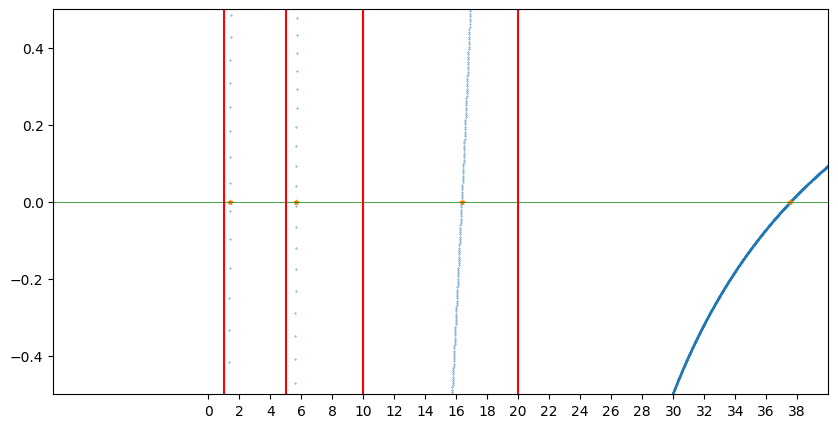

In [ ]:
def f(d, rho, u, l, n):
    return 1 + rho * np.sum([u[i]**2 / (d[i]-l) for i in range(n)])

def df(d, rho, u, l, n, eps=1e-16):
    return (f(d, rho, u, l+eps, n) - f(d, rho, u, l, n)) / eps

def df_special(d, rho, u, l, n):
    return rho * np.sum([u[i]**2 / (d[i]-l)**2 for i in range(n)])

def NewtonMethod(d1, d2, d, rho, u, n, f, df=None, eps=1e-13):
    # немодифицированный метод Ньютона
    x1 = (d1+d2)/2
    x2 = d1
    while np.abs(x1 - x2) > eps:
        x2 = x1
        f_x1 = f(d, rho, u, x1, n)
        df_x1 = df(d, rho, u, x1, n)
        df_sp = df_special(d, rho, u, x1, n)
        # print(x1, f_x1, df_x1, df_sp)
        x1 = x1 - f_x1 / df_sp
        if x1 > d2:
            x1 = d2 - (d2 - d1)/100
        elif x1 < d1:
            x1 = d1 + (d2 - d1)/100
        # print("x new: ", x1)

    return x1


d = [1, 5, 10, 20]
rho = 1.5
n = 4
u = [1, -1.4, 3.11, -2]

x = np.linspace(-10, 60, 10000)
y = np.zeros_like(x)
for i, x_i in enumerate(x):
    y[i] = f(d, rho, u, x_i, n)

plt.figure(figsize=(10, 5))
plt.scatter(x, y, s=0.1)
plt.hlines([0, 1], -1000, 1000, colors='g', linewidth=0.5)
plt.vlines(d, -1000, 1000, colors='r')
plt.ylim(-0.5, 0.5)
plt.xlim(-10, 40)
plt.xticks(range(0, 40, 2))

L = []
for i in range(n-1):
    l = NewtonMethod(d[i], d[i+1], d, rho, u, n, f, df)
    L.append(l)

L.append(NewtonMethod(d[-1], d[-1]*100, d, rho, u, n, f, df))

plt.scatter(L, np.zeros(len(L)), marker="*", s=10)
plt.show();